In [27]:
import pickle as pk
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras as kr
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPool2D,
)
from tensorflow.keras.optimizers import Adam

In [2]:
# Config the GPU to use full VRAM limit
gpus = tf.config.list_physical_devices("GPU")
tf.config.set_logical_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=8000)],  # Set limit in MB
)
logical_gpus = tf.config.list_logical_devices("GPU")
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

2 Physical GPUs, 2 Logical GPUs


2024-04-13 17:35:59.299017: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 17:35:59.299165: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 17:35:59.319364: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# Load the processed data
with open("./processed_data/data.pickle", "rb") as f:
    processed_data = pk.load(f)
with open("./processed_data/training_data.pickle", "rb") as f:
    training_processed_data = pk.load(f)

In [4]:
# Unload the processed data to variables
X_train = training_processed_data["X_train"]
Y_train = training_processed_data["Y_train"]

X_valid = processed_data["X_valid"]
Y_valid = processed_data["Y_valid"]

X_test = processed_data["X_test"]
Y_test = processed_data["Y_test"]

In [7]:
X_train.shape

(3467, 224, 224, 3)

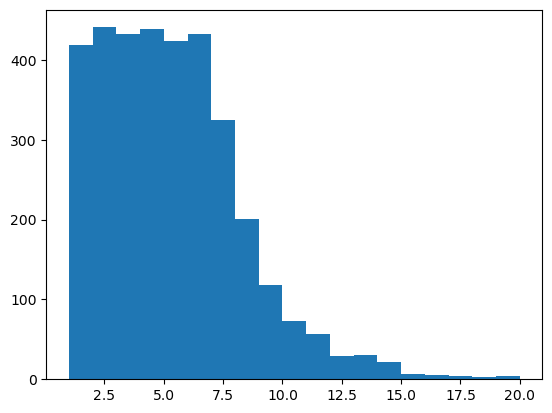

In [8]:
plt.hist(Y_train, bins=np.unique(Y_train))
plt.show()

In [9]:
# Load the VGG16 model with pre-trained weights (optional arguments)
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

base_model.summary()

2024-04-13 17:36:56.039535: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1101] failed to allocate 7.81GiB (8388608000 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
base_model.trainable = False

In [19]:
# Define the model with additional Conv2D layers and dense to a linear output
kr.backend.clear_session()
inputs = kr.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)

x = Conv2D(filters=512, kernel_size=(2, 2), activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Conv2D(filters=512, kernel_size=(2, 2), activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Conv2D(filters=512, kernel_size=(2, 2), activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPool2D(2)(x)
x = Flatten()(x)

x = Dense(
    512,
    activation="relu",
    kernel_initializer=HeNormal(),
)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(
    256,
    activation="relu",
    kernel_initializer=HeNormal(),
)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(
    256,
    activation="relu",
    kernel_initializer=HeNormal(),
)(x)
x = BatchNormalization()(x)

outputs = Dense(1, activation="linear")(x)
model = kr.Model(inputs, outputs)

model.compile(loss="mse", optimizer="adam")

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 512)         1049088   
                                                                 
 batch_normalization (BatchN  (None, 6, 6, 512)        2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 6, 6, 512)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 512)         1049088   
                                                             

In [21]:
es = kr.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

In [22]:
network_history = model.fit(
    X_train,
    Y_train,
    validation_data=(X_valid, Y_valid),
    batch_size=32,
    epochs=10000000000,
    verbose=2,
    callbacks=[es],
)

Epoch 1/10000000000


2024-04-13 17:42:25.955345: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


109/109 - 13s - loss: 22.1793 - val_loss: 55.0380 - 13s/epoch - 120ms/step
Epoch 2/10000000000
109/109 - 10s - loss: 8.7160 - val_loss: 8.8446 - 10s/epoch - 88ms/step
Epoch 3/10000000000
109/109 - 10s - loss: 5.9879 - val_loss: 6.0159 - 10s/epoch - 88ms/step
Epoch 4/10000000000
109/109 - 10s - loss: 5.4662 - val_loss: 6.0598 - 10s/epoch - 88ms/step
Epoch 5/10000000000
109/109 - 10s - loss: 4.3922 - val_loss: 4.8569 - 10s/epoch - 88ms/step
Epoch 6/10000000000
109/109 - 10s - loss: 3.8661 - val_loss: 6.1439 - 10s/epoch - 88ms/step
Epoch 7/10000000000
109/109 - 10s - loss: 3.2212 - val_loss: 3.7616 - 10s/epoch - 88ms/step
Epoch 8/10000000000
109/109 - 10s - loss: 2.8260 - val_loss: 4.3723 - 10s/epoch - 88ms/step
Epoch 9/10000000000
109/109 - 10s - loss: 2.4880 - val_loss: 3.9177 - 10s/epoch - 88ms/step
Epoch 10/10000000000
109/109 - 10s - loss: 2.1305 - val_loss: 3.0929 - 10s/epoch - 88ms/step
Epoch 11/10000000000
109/109 - 10s - loss: 1.8669 - val_loss: 3.4395 - 10s/epoch - 88ms/step
Epo

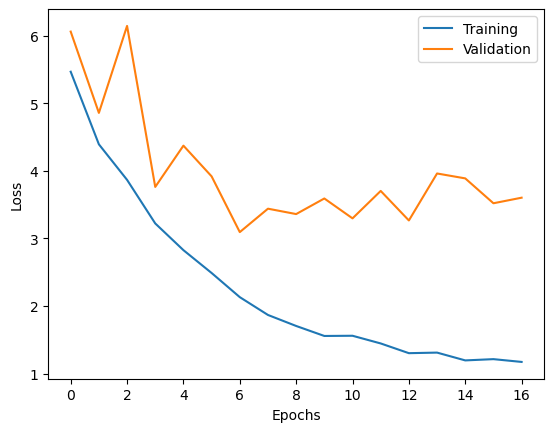

In [23]:
def plot_history(network_history, x):
    plt.figure()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(network_history.history["loss"][x:])
    plt.plot(network_history.history["val_loss"][x:])
    plt.legend(["Training", "Validation"])


plot_history(network_history, 3)

In [24]:
print(model.evaluate(X_test, Y_test))
preds = model.predict(X_test)
preds = np.round(preds)

32/32 [==============================] - 2s 74ms/step - loss: 7.0109
7.010907173156738
32/32 [==============================] - 2s 74ms/step


In [25]:
# Calculate the number of correct prediction by round the predicted linear output 
# and compare it with the ground truths
true_pred = 0
for truth, pred in zip(Y_test, preds):
    if truth == pred:
        true_pred += 1

print(f"Accuracy: {true_pred / len(Y_test) * 100}%")

Accuracy: 16.7%


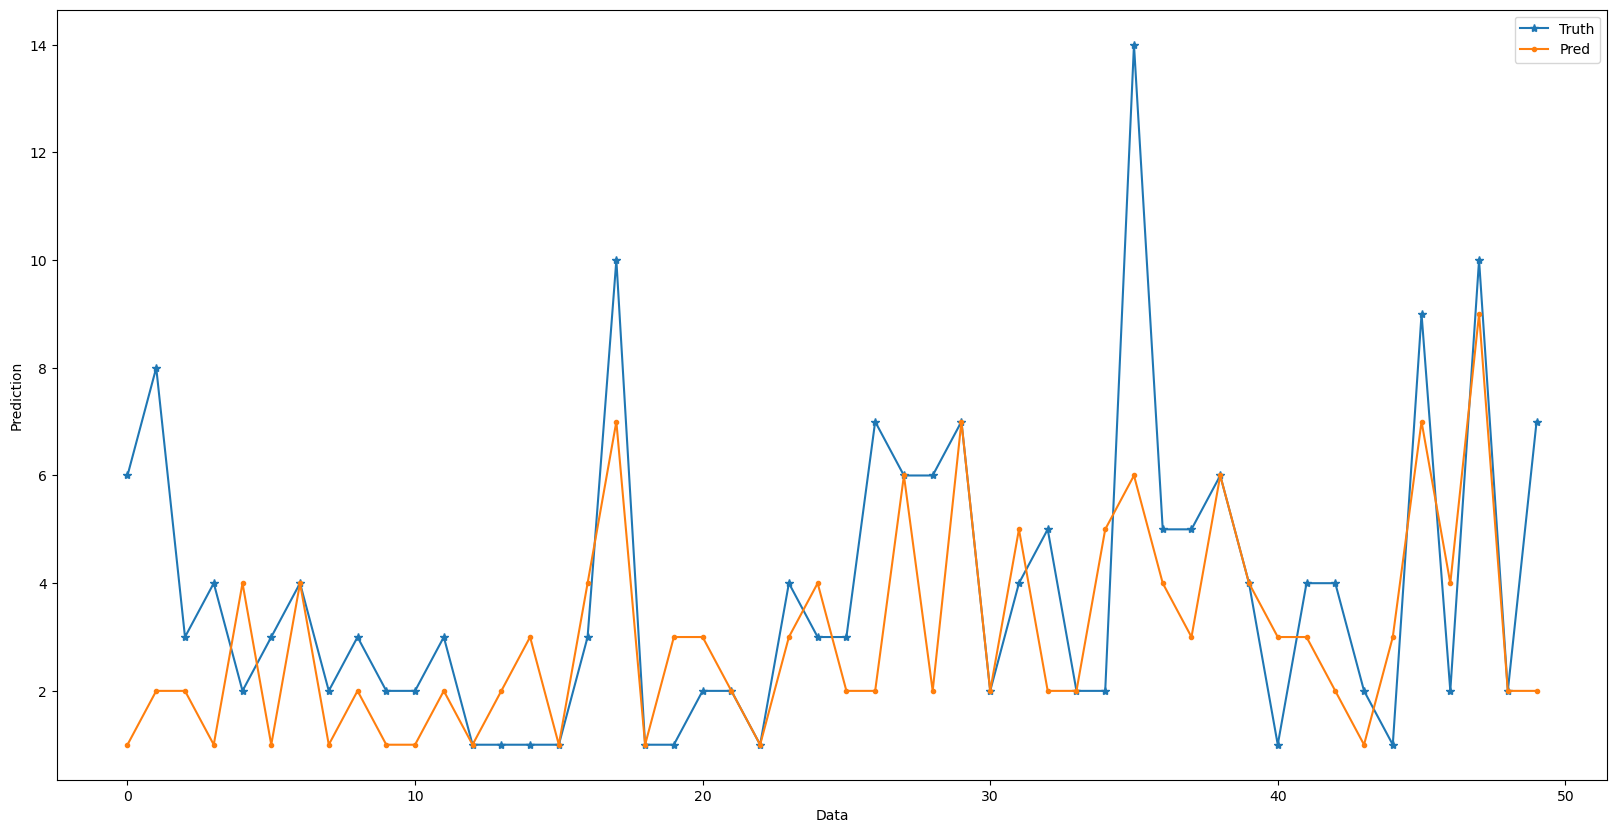

In [33]:
def plot_prediction(Y_test, preds):
    plt.figure(figsize=(20, 10))
    plt.xlabel("Data")
    plt.ylabel("Prediction")
    plt.plot(Y_test, marker="*")
    plt.plot(preds, marker=".")
    plt.legend(["Truth", "Pred"])


idx = 50
plot_prediction(Y_test[:idx], preds[:idx])

As we can see, the prediction is not very accurate.

In [29]:
# After train the new layers, we will try to train more on VGG16 also.
base_model.trainable = True

model.compile(loss="mse", optimizer=Adam(0.0001))
network_history = model.fit(
    X_t,
    Y_t,
    validation_data=(X_valid, Y_valid),
    batch_size=32,
    epochs=10000000000,
    verbose=2,
    callbacks=[es],
)

Epoch 1/10000000000


2024-04-13 20:22:33.975790: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-13 20:22:46.273814: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-13 20:22:46.997791: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


109/109 - 51s - loss: 6.6120 - val_loss: 10.0926 - 51s/epoch - 469ms/step
Epoch 2/10000000000
109/109 - 29s - loss: 6.3195 - val_loss: 5.8439 - 29s/epoch - 270ms/step
Epoch 3/10000000000
109/109 - 29s - loss: 5.3795 - val_loss: 15.1103 - 29s/epoch - 270ms/step
Epoch 4/10000000000
109/109 - 29s - loss: 4.6635 - val_loss: 7.8804 - 29s/epoch - 270ms/step
Epoch 5/10000000000
109/109 - 29s - loss: 4.2943 - val_loss: 4.8007 - 29s/epoch - 270ms/step
Epoch 6/10000000000
109/109 - 29s - loss: 4.0369 - val_loss: 4.9892 - 29s/epoch - 270ms/step
Epoch 7/10000000000
109/109 - 29s - loss: 3.5382 - val_loss: 4.8901 - 29s/epoch - 270ms/step
Epoch 8/10000000000
109/109 - 29s - loss: 3.1853 - val_loss: 3.9509 - 29s/epoch - 270ms/step
Epoch 9/10000000000
109/109 - 29s - loss: 2.9643 - val_loss: 7.0957 - 29s/epoch - 269ms/step
Epoch 10/10000000000
109/109 - 29s - loss: 2.5508 - val_loss: 3.3881 - 29s/epoch - 270ms/step
Epoch 11/10000000000
109/109 - 29s - loss: 2.2504 - val_loss: 4.3189 - 29s/epoch - 269m

32/32 [==============================] - 2s 74ms/step - loss: 5.3743
5.374334335327148
32/32 [==============================] - 2s 73ms/step
Accuracy: 25.1%


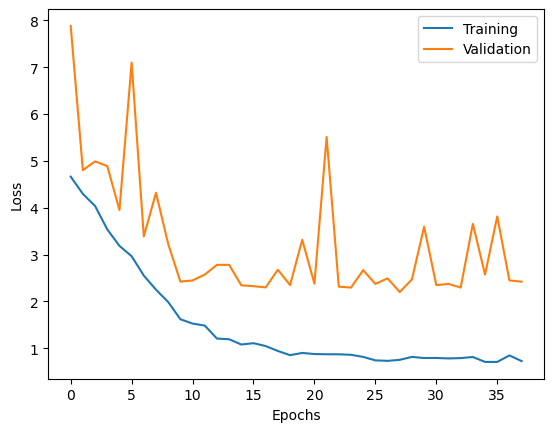

In [30]:
plot_history(network_history, 3)

print(model.evaluate(X_test, Y_test))
preds = model.predict(X_test)
preds = np.round(preds)

true_pred = 0
for truth, pred in zip(Y_test, preds):
    if truth == pred:
        true_pred += 1

print(f"Accuracy: {true_pred / len(Y_test) * 100}%")

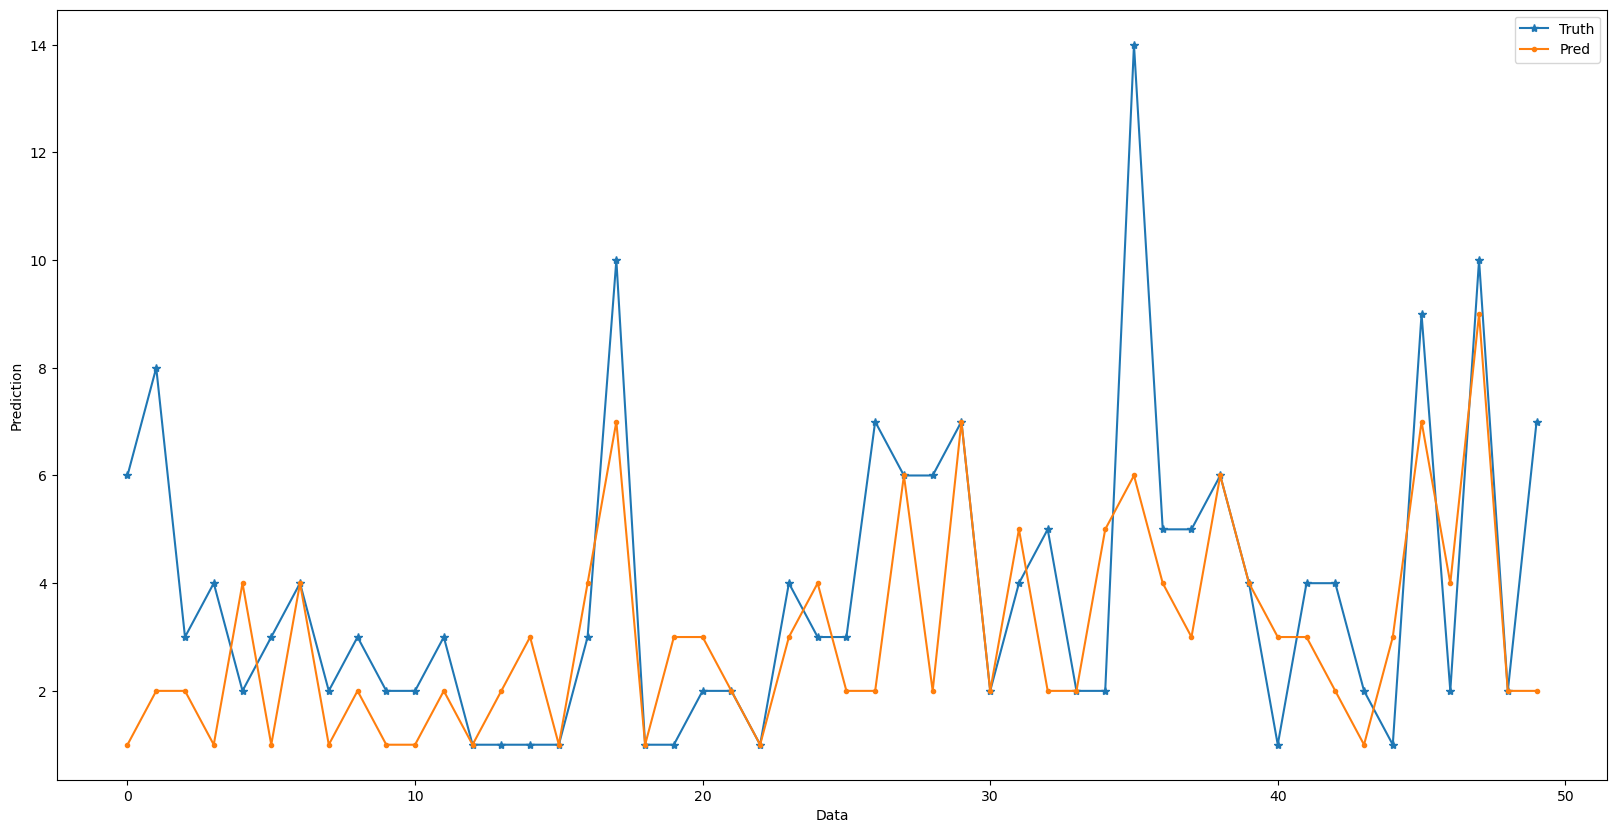

In [34]:
idx = 50
plot_prediction(Y_test[:idx], preds[:idx])

Hear, the accuracy does increase but the overall performance is still not very usable.
Thus, we proceed with the YoloV8-model-based approach.